# Embeddings analysis and 2D/3D projections


An embedding is a vector that represents the word or sentences in a high-dimensional space, such that elements with similar meanings are close together in this space. Embeddings make it easy for machine learning models and other algorithms to understand the relationships between content and to perform tasks like clustering or retrieval.

In [16]:
from pathlib import Path

from dotenv import load_dotenv, find_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from tqdm.autonotebook import tqdm

In [17]:
tqdm.pandas()

## Settings

Load OpenAI API key

In [9]:
load_dotenv()

True

Define the embedding model to use

In [10]:
EMBEDDING_MODEL = "text-embedding-3-large"

## Tooling

In [19]:
# Function to create the embeddings
client = OpenAI()

def get_embeddings(text, model=EMBEDDING_MODEL):
   return client.embeddings.create(
       input=[text],
       model=model
   ).data[0].embedding

In [20]:
def compute_pca(df, col_name="embeddings"):
    """Reduce the dimension of the embeddings with PCA
    """
    pca = PCA(n_components=3).fit(df[col_name].tolist())
    for idx, component in enumerate(pca.transform(df[col_name].tolist()).T, start=1):
        col_name = f"pca_comp_{idx}"
        df[col_name] = component
    
    labels = {
        idx: f"PCA compotent {idx} ({ratio*100:.0f} %)"
        for idx, ratio in enumerate(pca.explained_variance_ratio_, start=1)
    }
    return df, labels

In [28]:
def plot_2D_matplotlib(df, labels=None):
    """Get the list of categories."""
    categories = df["category"].unique().tolist()
    fig, ax = plt.subplots(figsize=(6, 6))
    for category in categories:
        ax.scatter(df[df["category"] == category]["pca_comp_1"], 
                    df[df["category"] == category]["pca_comp_2"], 
                    label=category)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[2])
    ax.set_title("2D projection of embeddings")
    ax.legend()
    plt.show()

In [35]:
def plot_2D_plotly(df, labels=None):
    fig = go.Figure()
    
    for category in categories:
        # Get data points
        x = df[df["category"] == category]["pca_comp_1"]
        y = df[df["category"] == category]["pca_comp_2"]
        # Get the text for hover
        hover_text = df[df["category"] == category]["text"]
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode="markers",
                marker=dict(size=8, colorscale="Viridis", opacity=0.8),
                name=category,
                hovertext=hover_text,
                hoverinfo="text",
            )
        )
    
    fig.update_layout(
        autosize=False,
        title="2D projection of embeddings",
        width=800,
        height=600,
        margin=dict(l=50, r=50, b=100, t=100, pad=10),
        xaxis=dict(title=labels[1]),
        yaxis=dict(title=labels[2]),
    )

    fig.show()

## Exploratory Data Analysis

### Load data

In [12]:
# Import the data
pd.set_option("display.max_colwidth", None)
df = pd.read_csv("sentence.csv", sep=",")
df

,category,text
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.
3,Programmation,Python est un langage polyvalent utilisé dans des domaines allant du développement de jeux à l'automatisation des tâches système.
4,Programmation,Les grandes entreprises telles que Google Facebook et Netflix font largement usage de Python dans leur infrastructure logicielle.
5,Programmation,Les listes en Python sont des structures de données flexibles et polyvalentes permettant de stocker et de manipuler des collections d'éléments.
6,Programmation,La vaste bibliothèque standard de Python offre des modules pour pratiquement toutes les tâches courantes de programmation.
7,Programmation,Les frameworks web populaires comme Django et Flask sont écrits en Python permettant un développement rapide et efficace des applications web.
8,Animaux,Le python royal est une espèce de serpent non venimeux originaire d'Afrique.
9,Animaux,Les pythons peuvent avaler des proies entières grâce à leur mâchoire extensible.


### Get embeddings

In [18]:
# Get embeddings, dimension and norm
pd.set_option("display.max_colwidth", 150)

df["embeddings"] = df["text"].progress_apply(get_embeddings)
df["embeddings_dim"] = df["embeddings"].apply(lambda x: len(x))
df["embeddings_norm"] = df["embeddings"].apply(lambda x: np.linalg.norm(x))
df.head(3)

  0%|          | 0/20 [00:00<?, ?it/s]

,category,text,embeddings,embeddings_dim,embeddings_norm
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.,"[-0.01979663595557213, 0.0003639243368525058, -0.012069671414792538, 0.026395514607429504, 0.02342686802148819, 0.013079010881483555, 0.0196439623...",3072,1.0
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.,"[-0.016689483076334, -0.01706320233643055, -0.019246505573391914, 0.01595188118517399, 0.04362672194838524, -0.005438588559627533, -0.001374399173...",3072,1.0
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.,"[0.011798487976193428, 0.0072993808425962925, -0.0020477003417909145, 0.018304457888007164, -0.004055730067193508, 0.006123265717178583, 0.0145707...",3072,1.0


The dimension of the embeddings is 3072, that is coherent with the [documentation](https://platform.openai.com/docs/guides/embeddings/embeddings) for the model used.

The norm of embeddings vector is 1 for all the embeddings, which means that the embeddings are normalized. This is a common practice in machine learning to normalize the embeddings to make the training process easier.

### PCA

In [30]:
df, component_labels = compute_pca(df, col_name="embeddings")
df.head(3)

,category,text,embeddings,embeddings_dim,embeddings_norm,pca_comp_1,pca_comp_2,pca_comp_3
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.,"[-0.01979663595557213, 0.0003639243368525058, -0.012069671414792538, 0.026395514607429504, 0.02342686802148819, 0.013079010881483555, 0.0196439623...",3072,1.0,0.466166,0.033150,0.194229
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.,"[-0.016689483076334, -0.01706320233643055, -0.019246505573391914, 0.01595188118517399, 0.04362672194838524, -0.005438588559627533, -0.001374399173...",3072,1.0,0.401231,-0.236807,-0.045365
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.,"[0.011798487976193428, 0.0072993808425962925, -0.0020477003417909145, 0.018304457888007164, -0.004055730067193508, 0.006123265717178583, 0.0145707...",3072,1.0,0.411000,-0.029979,0.042367


### 2D projection of embeddings

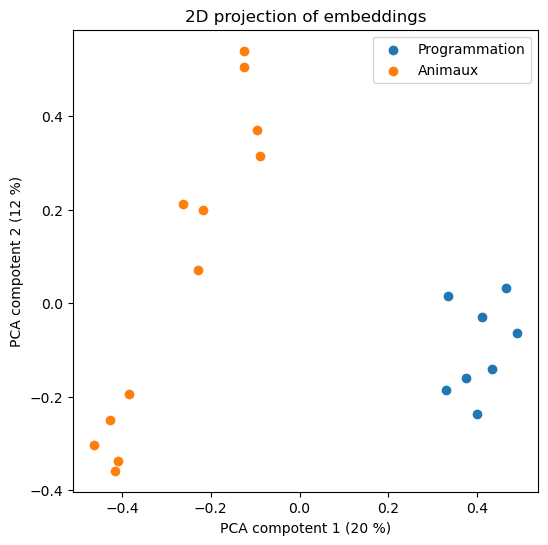

In [31]:
# with Matplotlib
plot_2D_matplotlib(df, labels=component_labels)

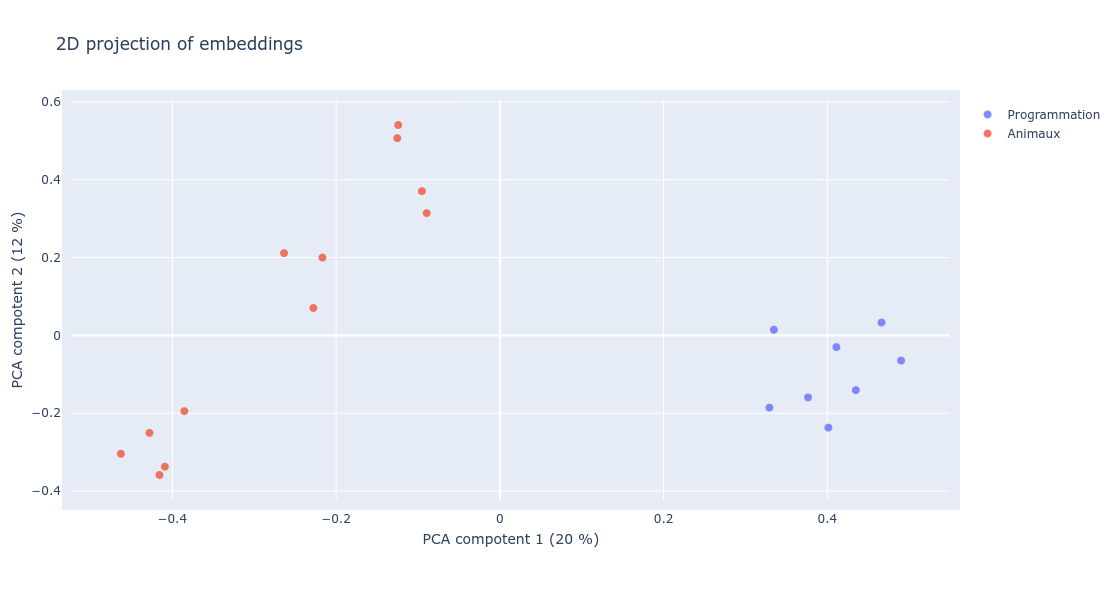

In [36]:
# with Plotly
plot_2D_plotly(df,  labels=component_labels)

### 3D projection of embeddings

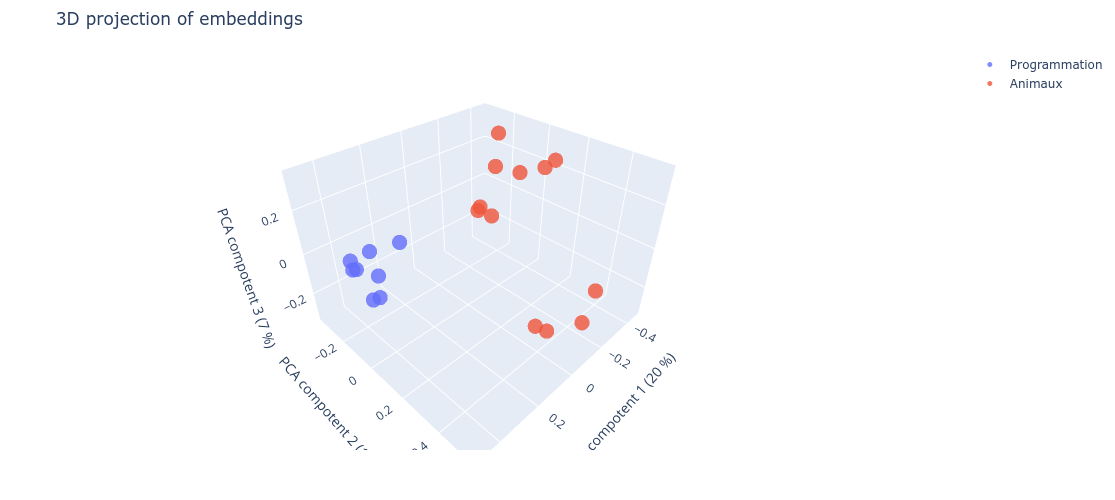

In [90]:
# Display the 3D Scatter Plot of Categories
fig = go.Figure()

for category in categories:
    # Get data points
    x = df[df["category"] == category]["pca_comp_1"]
    y = df[df["category"] == category]["pca_comp_2"]
    z = df[df["category"] == category]["pca_comp_3"]
    # Set the hover text
    hover_text = df[df["category"] == category]["text"]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(size=5, color=i, colorscale="Viridis", opacity=0.8),
            name=category,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="3D projection of embeddings",
    width=800,
    height=500,
    margin=dict(l=10, r=10, b=50, t=50, pad=10),
    scene=dict(
        xaxis=dict(title=component_labels[1]),
        yaxis=dict(title=component_labels[2]),
        zaxis=dict(title=component_labels[3]),
    ),
)

fig.show()

## Application to the content of Python course chapters

Markdown files should be in `../markdown_raw`

In [135]:
# Path to the chapters
markdown_path = "../data/markdown_raw"

# Define chapters
chapters = [
    {"name": "Affichage", "filename": "03_affichage.md"},
    {"name": "Listes", "filename": "04_listes.md"},
    {"name": "Fonctions", "filename": "09_fonctions.md"},
    {"name": "Jupyter", "filename": "18_jupyter.md"},
]

The question is:

> **Can we correctly separate the chunks of these 4 chapters or are they a bit mixed up?**

In [136]:
# Get the content of the chapters
chapter_content = {}

for chapter in chapters:
    f_in = Path(markdown_path) / chapter["filename"]
    chapter_content[chapter["name"]] = f_in.read_text()

chapter_content.keys()

dict_keys(['Affichage', 'Listes', 'Fonctions', 'Jupyter'])

In [137]:
# Split content into chunks
def split_text(text: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """"
    Split the text into chunks of the specified size and overlap

    Parameters
    ----------
    text : str
        The text to split into chunks
    chunk_size : int
        The size of each chunk
    chunk_overlap : int
        The overlap between each chunk
    
    Returns
    -------
    chunks : list[str]
        A list of text chunks

    """
    # Create a character-based text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        # split on paragraphs, sentences
        separators=["\n\n", "\n"],
    )
    # Split the resulting chunks further based on character limits
    chunks = text_splitter.split_text(text)

    return chunks

In [138]:
# Split the content of the chapters
chapter_chunks = {}
for name, content in chapter_content.items():
    chunks = split_text(content, chunk_size=1000, chunk_overlap=200)
    chapter_chunks[name] = chunks

for chapter, chunks in chapter_chunks.items():
    print(f"Chapter: {chapter}")
    print(f"Number of Chunks: {len(chunks)}")
    print("\n")

Chapter: Affichage
Number of Chunks: 30


Chapter: Listes
Number of Chunks: 14


Chapter: Fonctions
Number of Chunks: 33


Chapter: Jupyter
Number of Chunks: 14




In [139]:
df = pd.DataFrame(columns=["chapter", "chunk"])
for chapter, chunks in chapter_chunks.items():
    df = pd.concat([
        df,
        pd.DataFrame({"chapter": [chapter]*len(chunks), "chunk": chunks})
        ], ignore_index=True
    )

df

,chapter,chunk
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le..."
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est que les trois chevrons `>>>` se retrouvent collés après la chaîne de caractères `""Hello world!""`.\n\nU..."
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> print(nom, ""a"", x, ""ans"")\nJohn a 32 ans\n```\n\nPython a écrit une phrase complète en remplaçant les..."
3,Affichage,"Pour afficher deux chaînes de caractères l'une à côté de l'autre, sans espace, on peut soit les concaténer, soit utiliser l'argument par mot-clé `..."
4,Affichage,"close-box-def\n\nDepuis la version 3.6, Python a introduit les *f-strings* pour mettre en place l'écriture formatée que nous allons décrire en dét..."
...,...,...
86,Jupyter,Notez qu'une cellule Markdown n'a pas le marqueur `In [ ]` à sa gauche.\n\nLe format Markdown permet de rapidement et très simplement rédiger du t...
87,Jupyter,"![Incorporation d'un graphique dans un notebook Jupyter.](img/jupyter-matplotlib.png ""Incorporation d'un graphique dans un notebook Jupyter.""){ #f..."
88,Jupyter,"close-box-rem\n\n\n## Les *magic commands*\n\nLa commande précédente (`%matplotlib inline`) est une *magic command*. Il en existe beaucoup, en voi..."
89,Jupyter,![Lancement d'une commande Unix.](img/jupyter-ls.png){ #fig:jupyter-ls width=80% }\n\nopen-box-rem\n\nLe lancement de n'importe quelle commande Un...


In [140]:
# Get the list of chapters
chapters = df["chapter"].unique().tolist()
chapters

['Affichage', 'Listes', 'Fonctions', 'Jupyter']

### Get embeddings

In [141]:
# Get embeddings, dimension and norm
pd.set_option("display.max_colwidth", 150)

df["embeddings"] = df["chunk"].apply(get_embeddings)
df["embeddings_dim"] = df["embeddings"].apply(lambda x: len(x))
df["embeddings_norm"] = df["embeddings"].apply(lambda x: np.linalg.norm(x))
df.head(3)

,chapter,chunk,embeddings,embeddings_dim,embeddings_norm
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le...","[0.013749700039625168, 0.004799423739314079, 0.0009146321681328118, 0.03575393557548523, -0.02669752947986126, -0.043489616364240646, 0.0012381805...",3072,1.0
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est que les trois chevrons `>>>` se retrouvent collés après la chaîne de caractères `""Hello world!""`.\n\nU...","[0.019545402377843857, -0.0049816519021987915, -0.009379944764077663, 0.047592826187610626, -0.00587979331612587, -0.025251921266317368, -0.017985...",3072,1.0
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> print(nom, ""a"", x, ""ans"")\nJohn a 32 ans\n```\n\nPython a écrit une phrase complète en remplaçant les...","[0.04040946066379547, -0.006302121095359325, -0.011963951401412487, 0.046504080295562744, 0.016185127198696136, -0.006906840018928051, 0.008857355...",3072,1.0


### PCA

In [142]:
pca = PCA(n_components=3).fit(df["embeddings"].tolist())
for idx, component in enumerate(pca.transform(df["embeddings"].tolist()).T, start=1):
    col_name = f"pca_comp_{idx}"
    df[col_name] = component


component_labels = {
    idx: f"PCA compotent {idx} ({ratio*100:.0f} %)"
    for idx, ratio in enumerate(pca.explained_variance_ratio_, start=1)
}

df.head(3)

,chapter,chunk,embeddings,embeddings_dim,embeddings_norm,pca_comp_1,pca_comp_2,pca_comp_3
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le...","[0.013749700039625168, 0.004799423739314079, 0.0009146321681328118, 0.03575393557548523, -0.02669752947986126, -0.043489616364240646, 0.0012381805...",3072,1.0,0.024603,-0.008120,-0.032844
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est que les trois chevrons `>>>` se retrouvent collés après la chaîne de caractères `""Hello world!""`.\n\nU...","[0.019545402377843857, -0.0049816519021987915, -0.009379944764077663, 0.047592826187610626, -0.00587979331612587, -0.025251921266317368, -0.017985...",3072,1.0,0.138866,-0.061333,0.047900
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> print(nom, ""a"", x, ""ans"")\nJohn a 32 ans\n```\n\nPython a écrit une phrase complète en remplaçant les...","[0.04040946066379547, -0.006302121095359325, -0.011963951401412487, 0.046504080295562744, 0.016185127198696136, -0.006906840018928051, 0.008857355...",3072,1.0,0.171965,-0.040078,0.048338


### 2D projection of embeddings

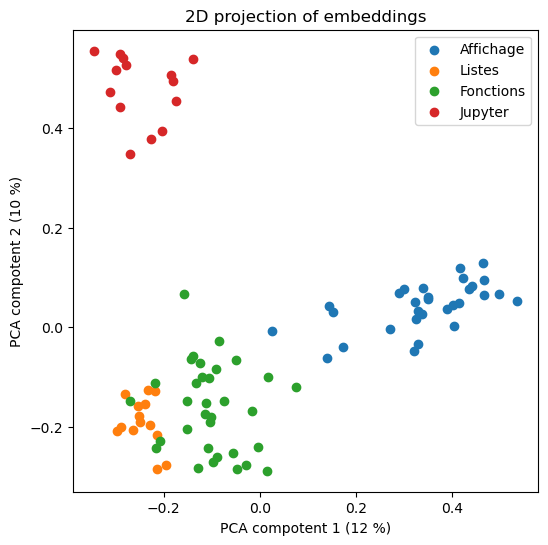

In [143]:
# with Matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

for chapter in chapters:
    ax.scatter(df[df["chapter"] == chapter]["pca_comp_1"], 
                df[df["chapter"] == chapter]["pca_comp_2"], 
                label=chapter)
    
ax.set_xlabel(component_labels[1])
ax.set_ylabel(component_labels[2])
ax.set_title("2D projection of embeddings")
ax.legend()
plt.show()

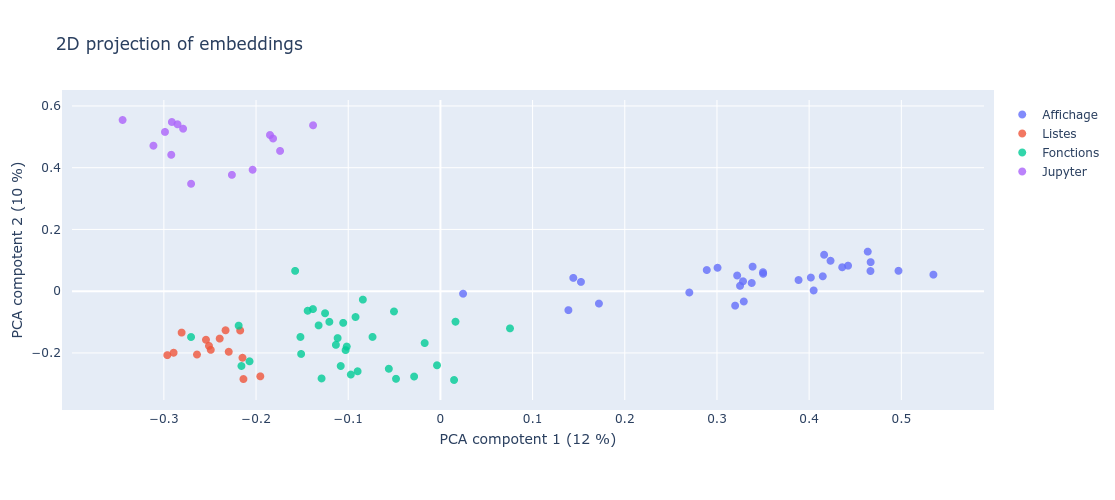

In [145]:
# with Plotly
fig = go.Figure()

for chapter in chapters:
    # Get data points
    x = df[df["chapter"] == chapter]["pca_comp_1"]
    y = df[df["chapter"] == chapter]["pca_comp_2"]
    # Get the text for hover
    hover_text = df[df["chapter"] == chapter]["chunk"]
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode="markers",
            marker=dict(size=8, colorscale="Viridis", opacity=0.8),
            name=chapter,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="2D projection of embeddings",
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=10),
    xaxis=dict(title=component_labels[1]),
    yaxis=dict(title=component_labels[2]),
)

fig.show()

### 3D projection of embeddings

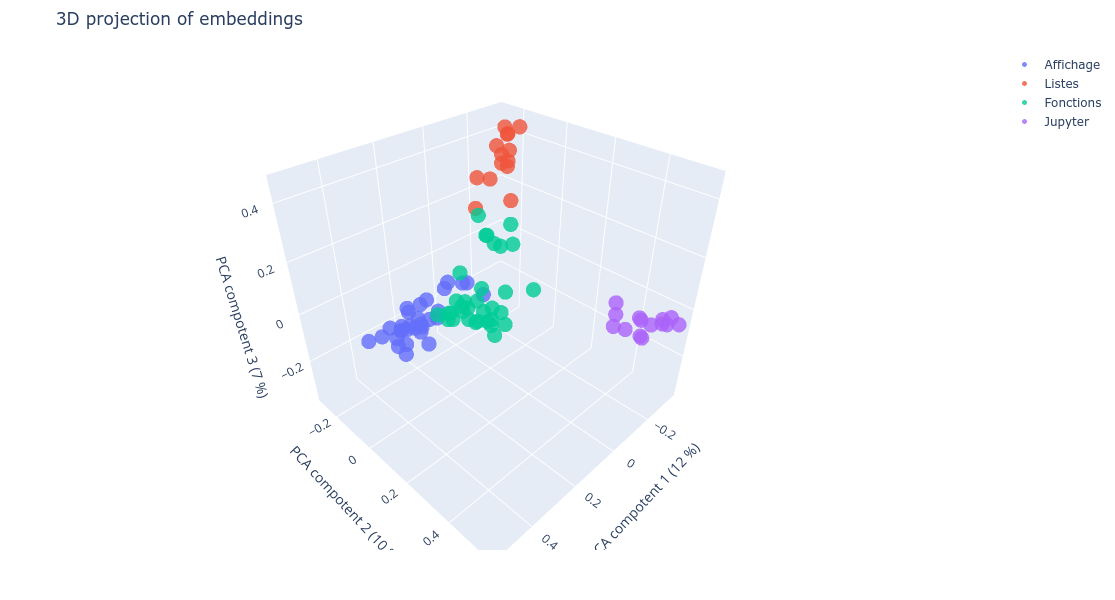

In [152]:
# Display the 3D Scatter Plot of Categories
fig = go.Figure()

for chapter in chapters:
    # Get data points
    x = df[df["chapter"] == chapter]["pca_comp_1"]
    y = df[df["chapter"] == chapter]["pca_comp_2"]
    z = df[df["chapter"] == chapter]["pca_comp_3"]
    # Set the hover text
    hover_text = df[df["chapter"] == chapter]["chunk"]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(size=5, color=i, colorscale="Viridis", opacity=0.8),
            name=chapter,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="3D projection of embeddings",
    width=800,
    height=600,
    margin=dict(l=10, r=10, b=50, t=50, pad=10),
    scene=dict(
        xaxis=dict(title=component_labels[1]),
        yaxis=dict(title=component_labels[2]),
        zaxis=dict(title=component_labels[3]),
    ),
)

fig.show()